In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from modules import data_loader, metrics, learning, plotting, utils, params
from modules.gmp_model import GMP
import matplotlib.pyplot as plt
import numpy as np
import torch


Load data from files and init acpr meter

In [4]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
sub_ch = config["sub_ch"]
nperseg = config["nperseg"]

x_train = data["train_input"]
y_train = data["train_output"]
x_val = data["val_input"]
y_val = data["val_output"]

gain = metrics.calculate_gain_complex(x_train, y_train)
print(f"Gain of PA = {gain:.2f}")
y_train_target = gain * x_train
y_val_target = gain * x_val

data['y_train_target'] = y_train_target
data['y_val_target'] = y_val_target


acpr_meter = metrics.ACPR(
        sample_rate=fs,
        main_measurement_bandwidth=bw_main_ch,
        adjacent_channel_offset=[-sub_ch, sub_ch],
        segment_length=nperseg,
        overlap_percentage=60,
        window='blackmanharris',
        fft_length=nperseg,
        power_units='dBW',
        return_main_power=True,
        return_adjacent_powers=True
    )


Gain of PA = 2.52


In [36]:
pa_train_loader = [(x_train, y_train)]
pa_val_loader = [(x_val, y_val)]
criterion = metrics.compute_mse
metric_criterion = metrics.compute_nmse

pa_degree = 6
pa_config = params.make_gmp_params(
    Ka=pa_degree,
    La=pa_degree,
    Kb=pa_degree,
    Lb=pa_degree,
    Mb=pa_degree,
    Kc=pa_degree,
    Lc=pa_degree,
    Mc=pa_degree,
    model_type="pa_grad"
)

pa_model = GMP(**pa_config)

epochs = 10000
lr = 0.001

optimizer = torch.optim.Adam(pa_model.parameters(), lr=lr)

if not pa_model.load_weights():
      learning.train(net=pa_model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=pa_train_loader, 
            val_loader=pa_val_loader, 
            n_epochs=epochs, 
            metric_criterion=metric_criterion)
      pa_model.save_weights()
utils.freeze_pa_model(pa_model)

y_val_pa = learning.net_inference(net=pa_model, x=x_val)
pa_nmse = metrics.compute_nmse(y_val_pa, y_val)
print(f"Model NMSE: {pa_nmse:.2f}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka6_La6_Kb6_Lb6_Mb6_Kc6_Lc6_Mc6.pt
Model NMSE: -33.27


PA model

In [32]:
pa_degree = 5
pa_config = params.make_gmp_params(
    Ka=pa_degree,
    La=pa_degree,
    Kb=pa_degree,
    Lb=pa_degree,
    Mb=pa_degree,
    Kc=pa_degree,
    Lc=pa_degree,
    Mc=pa_degree,
    model_type="pa_grad"
)

pa_model = GMP(**pa_config)

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not pa_model.load_weights():
    pa_model.optimize_weights(x_train, y_train, epochs=10000, learning_rate=0.01)
    pa_model.save_weights()
# else:
#     pa_model.optimize_weights(x_train, y_train, epochs=20000, learning_rate=0.00001)
#     pa_model.save_weights()

y_gmp_pa = pa_model.forward(x_val).detach()

nmse_pa = metrics.compute_nmse(y_gmp_pa, y_val)
print(f"NMSE PA: {nmse_pa}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
NMSE PA: -33.15937423706055


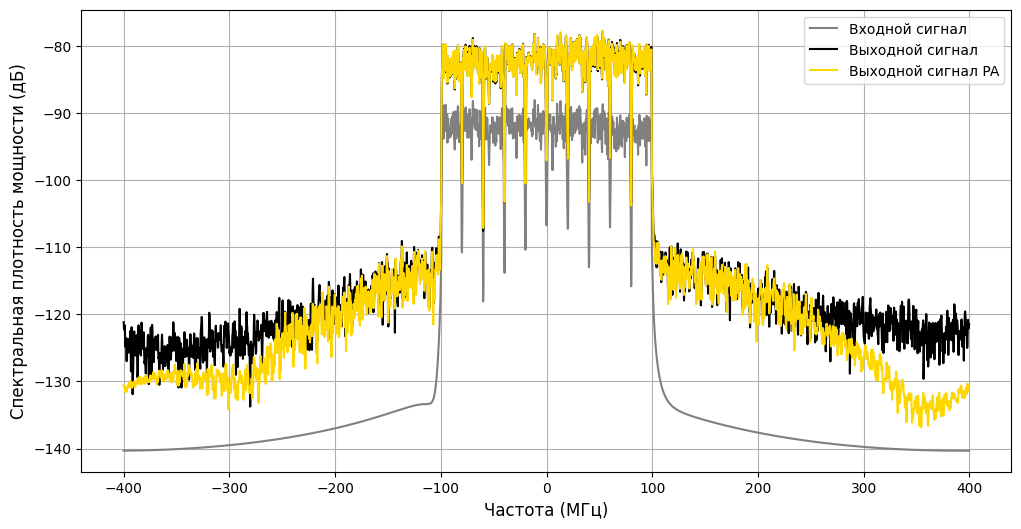

In [37]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_val_pa, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_out)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал PA')

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


DLA DPD grad

In [40]:
dla_train_loader = [(x_train, y_train_target)]
dla_val_loader = [(x_val, y_val_target)]

epochs = 1000
lr = 0.001

dla_degree = 6
dla_config = params.make_gmp_params(
    Ka=dla_degree,
    La=dla_degree,
    Kb=dla_degree,
    Lb=dla_degree,
    Mb=dla_degree,
    Kc=dla_degree,
    Lc=dla_degree,
    Mc=dla_degree,
    model_type="dpd_dla_grad"
)
dpd_model_dla = GMP(**dla_config)
is_load = dpd_model_dla.load_weights()
casc_dla = utils.CascadeModel(model_1=dpd_model_dla, model_2=pa_model, cascade_type="dla")

optimizer_dla = torch.optim.Adam(casc_dla.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_dla, 
                   criterion=criterion, 
                   optimizer=optimizer_dla, 
                   train_loader=dla_train_loader, 
                   val_loader=dla_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_dla.save_weights()

y_val_dla = learning.net_inference(net=casc_dla, x=x_val)
nmse_dla = metrics.compute_nmse(y_val_dla, y_val_target)
print(f"Model NMSE: {nmse_dla:.2f}")



Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka6_La6_Kb6_Lb6_Mb6_Kc6_Lc6_Mc6.pt
Model NMSE: -42.10


In [ ]:
# dla_degree = 5
# dla_config = params.make_gmp_params(
#     Ka=dla_degree,
#     La=dla_degree,
#     Kb=dla_degree,
#     Lb=dla_degree,
#     Mb=dla_degree,
#     Kc=dla_degree,
#     Lc=dla_degree,
#     Mc=dla_degree,
#     model_type="dpd_dla_grad"
# )

# dpd_model_dla_grad = GMP(**dla_config)

# if not dpd_model_dla_grad.load_weights():
#     learning.optimize_dla(x_train, y_train_target, dpd_model_dla_grad, pa_model, epochs=1000, learning_rate=0.01)
#     dpd_model_dla_grad.save_weights()

# # else:
# #     learning.optimize_dla_grad(x_train, y_train_target, dpd_model_dla_grad, pa_model, epochs=1000, learning_rate=0.001)
# #     dpd_model_dla_grad.save_weights()

# y_dpd_dla_grad = dpd_model_dla_grad.forward(x_val).detach()
# y_linearized_dla_grad = pa_model.forward(y_dpd_dla_grad).detach()

# nmse_dla = metrics.compute_nmse(y_linearized_dla_grad, y_val_target)
# print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla}")

Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
NMSE на выходе усилителя (DLA DPD): -34.0307731628418


ILA DPD grad

In [42]:
ila_train_loader = [(x_train, x_train)]
ila_val_loader = [(x_val, x_val)]

epochs = 1000
lr = 0.001

ila_degree = 6
ila_config = params.make_gmp_params(
    Ka=ila_degree,
    La=ila_degree,
    Kb=ila_degree,
    Lb=ila_degree,
    Mb=ila_degree,
    Kc=ila_degree,
    Lc=ila_degree,
    Mc=ila_degree,
    model_type="dpd_ila_grad"
)
dpd_model_ila = GMP(**ila_config)

is_load = dpd_model_ila.load_weights()
casc_ila_train = utils.CascadeModel(model_2=dpd_model_ila, model_1=pa_model, gain=gain, cascade_type="ila")
casc_ila_eval = utils.CascadeModel(model_1=dpd_model_ila, model_2=pa_model, cascade_type="dla")

optimizer = torch.optim.Adam(casc_ila_train.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_ila_train, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   train_loader=ila_train_loader, 
                   val_loader=ila_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_ila.save_weights()

y_val_ila = learning.net_inference(net=casc_ila_eval, x=x_val)
nmse_ila = metrics.compute_nmse(y_val_ila, y_val_target)
print(f"Model NMSE: {nmse_ila:.2f}")


Coefficients loaded from model_params/dpd_ila_grad_gmp_model_Ka6_La6_Kb6_Lb6_Mb6_Kc6_Lc6_Mc6.pt
Model NMSE: -40.17


In [ ]:
# ila_degree = 5
# ila_config = params.make_gmp_params(
#     Ka=ila_degree,
#     La=ila_degree,
#     Kb=ila_degree,
#     Lb=ila_degree,
#     Mb=ila_degree,
#     Kc=ila_degree,
#     Lc=ila_degree,
#     Mc=ila_degree,
#     model_type="dpd_ila_grad"
# )

# dpd_model_ila_grad = GMP(**ila_config)

# if not dpd_model_ila_grad.load_weights():
#     learning.optimize_ila(dpd_model_ila_grad, x_train, y_train, gain, epochs=1000, learning_rate=0.01)
#     dpd_model_ila_grad.save_weights()

# y_dpd_ila_grad = dpd_model_ila_grad.forward(x_val).detach()
# y_linearized_ila_grad = pa_model.forward(y_dpd_ila_grad).detach()

# nmse_ila = metrics.compute_nmse(y_linearized_ila_grad, y_val_target)
# print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila}")


No saved coefficients found at model_params/dpd_ila_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt, initializing new parameters.
Compute on presaved output_data
Epoch [0/1000], Loss: 0.05978816747665405
Epoch [100/1000], Loss: 9.820945706451312e-05
Epoch [200/1000], Loss: 7.30760584701784e-05
Epoch [300/1000], Loss: 6.624432717217132e-05
Epoch [400/1000], Loss: 6.335095531539991e-05
Epoch [500/1000], Loss: 6.191200372995809e-05
Epoch [600/1000], Loss: 6.107644730946049e-05
Epoch [700/1000], Loss: 6.0525082517415285e-05
Epoch [800/1000], Loss: 6.01253668719437e-05
Epoch [900/1000], Loss: 5.9816386055899784e-05
ILA-DPD Training Complete.
Coefficients saved to model_params/dpd_ila_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
NMSE на выходе усилителя (ILA DPD): -45.53754806518555


ILC DPD grad

In [43]:
u_k_train = learning.ilc_signal(x_train, y_train_target, pa_model, epochs=1000, learning_rate=0.001)
u_k_val = learning.ilc_signal(x_val, y_val_target, pa_model, epochs=1000, learning_rate=0.001)
u_k_pa = pa_model.forward(u_k_train).detach()

data["ilc_train_output"] = u_k_train
data["ilc_val_output"] = u_k_val

ilc_train_loader = [(x_train, u_k_train)]
ilc_val_loader = [(x_val, u_k_val)]

Epoch [0/1000], Loss: 0.030526617541909218
Epoch [100/1000], Loss: 0.0010766324121505022
Epoch [200/1000], Loss: 3.088106677751057e-05
Epoch [300/1000], Loss: 1.1305234011160792e-06
Epoch [400/1000], Loss: 2.0149145996128937e-07
Epoch [500/1000], Loss: 9.494502251072845e-08
Epoch [600/1000], Loss: 5.966557381498205e-08
Epoch [700/1000], Loss: 4.290076560664602e-08
Epoch [800/1000], Loss: 3.3465212823102775e-08
Epoch [900/1000], Loss: 2.763145445783266e-08
Epoch [0/1000], Loss: 0.03022262267768383
Epoch [100/1000], Loss: 0.0010722114238888025
Epoch [200/1000], Loss: 3.105450014118105e-05
Epoch [300/1000], Loss: 1.0806695627252338e-06
Epoch [400/1000], Loss: 2.122191773423765e-07
Epoch [500/1000], Loss: 1.18023400830225e-07
Epoch [600/1000], Loss: 8.437982046416437e-08
Epoch [700/1000], Loss: 6.705914046278849e-08
Epoch [800/1000], Loss: 5.7004982068065146e-08
Epoch [900/1000], Loss: 5.083052556642542e-08


In [ ]:
# u_k = learning.ilc_signal(x_train, y_train_target, pa_model, epochs=1000, learning_rate=0.001)

# u_k_pa = pa_model.forward(u_k).detach()

Epoch [0/1000], Loss: 0.030525214970111847
Epoch [100/1000], Loss: 0.0010581662645563483
Epoch [200/1000], Loss: 2.757479524007067e-05
Epoch [300/1000], Loss: 1.1750827297873911e-06
Epoch [400/1000], Loss: 3.8611705122093554e-07
Epoch [500/1000], Loss: 1.8952907510083605e-07
Epoch [600/1000], Loss: 9.509734155699334e-08
Epoch [700/1000], Loss: 7.100277343852213e-08
Epoch [800/1000], Loss: 6.088126980330344e-08
Epoch [900/1000], Loss: 5.490905508054311e-08


In [44]:
epochs = 1000
lr = 0.001

ilc_degree = 6
ilc_config = params.make_gmp_params(
    Ka=ilc_degree,
    La=ilc_degree,
    Kb=ilc_degree,
    Lb=ilc_degree,
    Mb=ilc_degree,
    Kc=ilc_degree,
    Lc=ilc_degree,
    Mc=ilc_degree,
    model_type="dpd_ilc_grad"
)

dpd_model_ilc = GMP(**ilc_config)
is_load = dpd_model_ilc.load_weights()
optimizer = torch.optim.Adam(dpd_model_ilc.parameters(), lr=lr)

if not is_load:
    learning.train(net=dpd_model_ilc, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   train_loader=ilc_train_loader, 
                   val_loader=ilc_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_ilc.save_weights()

casc_ilc_eval = utils.CascadeModel(model_1=dpd_model_ilc, model_2=pa_model, cascade_type="dla")
y_val_ilc = learning.net_inference(net=casc_ilc_eval, x=x_val)
nmse_ilc = metrics.compute_nmse(y_val_ilc, y_val_target)
print(f"Model NMSE: {nmse_ilc:.2f}")


No saved coefficients found at model_params/dpd_ilc_grad_gmp_model_Ka6_La6_Kb6_Lb6_Mb6_Kc6_Lc6_Mc6.pt, initializing new parameters.
===Start training===
Epoch 00 — train_loss: 0.038153, val_loss: 0.032611, val_NMSE: -3.76
Epoch 01 — train_loss: 0.031808, val_loss: 0.026950, val_NMSE: -4.59
Epoch 02 — train_loss: 0.026294, val_loss: 0.022066, val_NMSE: -5.46
Epoch 03 — train_loss: 0.021509, val_loss: 0.017961, val_NMSE: -6.35
Epoch 04 — train_loss: 0.017519, val_loss: 0.014566, val_NMSE: -7.26
Epoch 05 — train_loss: 0.014262, val_loss: 0.011910, val_NMSE: -8.14
Epoch 06 — train_loss: 0.011737, val_loss: 0.009970, val_NMSE: -8.91
Epoch 07 — train_loss: 0.009885, val_loss: 0.008625, val_NMSE: -9.54
Epoch 08 — train_loss: 0.008574, val_loss: 0.007768, val_NMSE: -9.99
Epoch 09 — train_loss: 0.007710, val_loss: 0.007315, val_NMSE: -10.26
Epoch 10 — train_loss: 0.007228, val_loss: 0.007151, val_NMSE: -10.35
Epoch 11 — train_loss: 0.007032, val_loss: 0.007123, val_NMSE: -10.37
Epoch 12 — train

In [ ]:
# ilc_degree = 5
# ilc_config = params.make_gmp_params(
#     Ka=ilc_degree,
#     La=ilc_degree,
#     Kb=ilc_degree,
#     Lb=ilc_degree,
#     Mb=ilc_degree,
#     Kc=ilc_degree,
#     Lc=ilc_degree,
#     Mc=ilc_degree,
#     model_type="dpd_ilc_grad"
# )

# dpd_model_ilc_grad = GMP(**ilc_config)

# if not dpd_model_ilc_grad.load_weights():
#     dpd_model_ilc_grad.optimize_weights(x_train, u_k, epochs=1000, learning_rate=0.01)
#     dpd_model_ilc_grad.save_weights()

# y_dpd_ilc_grad = dpd_model_ilc_grad.forward(x_val).detach()
# y_linearized_ilc_grad = pa_model.forward(y_dpd_ilc_grad).detach()

# nmse_ilc = metrics.compute_nmse(y_linearized_ilc_grad, y_val_target)
# print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc}")

No saved coefficients found at model_params/dpd_ilc_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt, initializing new parameters.
Epoch [0/1000], Loss: 0.0376245491206646
Epoch [100/1000], Loss: 1.9409928427194245e-05
Epoch [200/1000], Loss: 8.86377165443264e-06
Epoch [300/1000], Loss: 6.408905392163433e-06
Epoch [400/1000], Loss: 5.4625511438644025e-06
Epoch [500/1000], Loss: 5.01711019751383e-06
Epoch [600/1000], Loss: 4.780535618920112e-06
Epoch [700/1000], Loss: 4.638907284970628e-06
Epoch [800/1000], Loss: 4.543212071439484e-06
Epoch [900/1000], Loss: 4.471923602977768e-06
Coefficients saved to model_params/dpd_ilc_grad_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
NMSE на выходе усилителя (ILC DPD): -48.63936996459961


Metrics

In [45]:
nmse_after_pa = metrics.compute_nmse(y_val_pa, y_val_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NMSE на выходе усилителя (без DPD): -14.12 db
NMSE на выходе усилителя (DLA DPD): -42.10 db
NMSE на выходе усилителя (ILA DPD): -40.17 db
NMSE на выходе усилителя (ILC DPD): -42.33 db


In [46]:
x_val_acpr = metrics.calculate_acpr(x_val, acpr_meter)
y_val_acpr = metrics.calculate_acpr(y_val, acpr_meter)
y_val_pa_acpr = metrics.calculate_acpr(y_val_pa, acpr_meter)
y_val_target_acpr = metrics.calculate_acpr(y_val_target, acpr_meter)

y_lin_dla_acpr = metrics.calculate_acpr(y_val_dla, acpr_meter)
y_lin_ila_acpr = metrics.calculate_acpr(y_val_ila, acpr_meter)
y_lin_ilc_acpr = metrics.calculate_acpr(y_val_ilc, acpr_meter)

print(f"x_val_acpr: {x_val_acpr}")
print(f"y_val_acpr: {y_val_acpr}")
print(f"y_val_pa_acpr: {y_val_pa_acpr}")
print(f"y_val_target_acpr: {y_val_target_acpr}")

print(f"lin_dla_acpr: {y_lin_dla_acpr}")
print(f"lin_ila_acpr: {y_lin_ila_acpr}")
print(f"lin_ilc_acpr: {y_lin_ilc_acpr}")


x_val_acpr: [-48.08083195 -48.40122574]
y_val_acpr: [-40.60778184 -38.20237847]
y_val_pa_acpr: [-43.92654548 -41.00424439]
y_val_target_acpr: [-48.08083304 -48.40122404]
lin_dla_acpr: [-49.40306527 -49.83722565]
lin_ila_acpr: [-48.85954811 -47.86422928]
lin_ilc_acpr: [-48.99611814 -48.34863677]


In [47]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, y_train_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(u_k_val, acpr_meter)
u_k_pa_acpr = metrics.calculate_acpr(u_k_pa, acpr_meter)

print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -75.05 db
u_k_acpr: [-40.28516205 -45.78635878]
u_k_pa_acpr: [-50.92436621 -50.3568662 ]


Spectrum

In [48]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_pa = metrics.power_spectrum(y_val_pa, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

# _, spectrum_y_dpd_dla = metrics.power_spectrum(y_dpd_dla, fs, nperseg)
# _, spectrum_y_dpd_ila = metrics.power_spectrum(y_dpd_ila, fs, nperseg)
# _, spectrum_y_dpd_ilc = metrics.power_spectrum(y_dpd_ilc, fs, nperseg)

_, spectrum_y_val_dla = metrics.power_spectrum(y_val_dla, fs, nperseg)
_, spectrum_y_val_ila = metrics.power_spectrum(y_val_ila, fs, nperseg)
_, spectrum_y_val_ilc = metrics.power_spectrum(y_val_ilc, fs, nperseg)


_, spectrum_u_k = metrics.power_spectrum(u_k_val, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)

c:\Users\maximp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


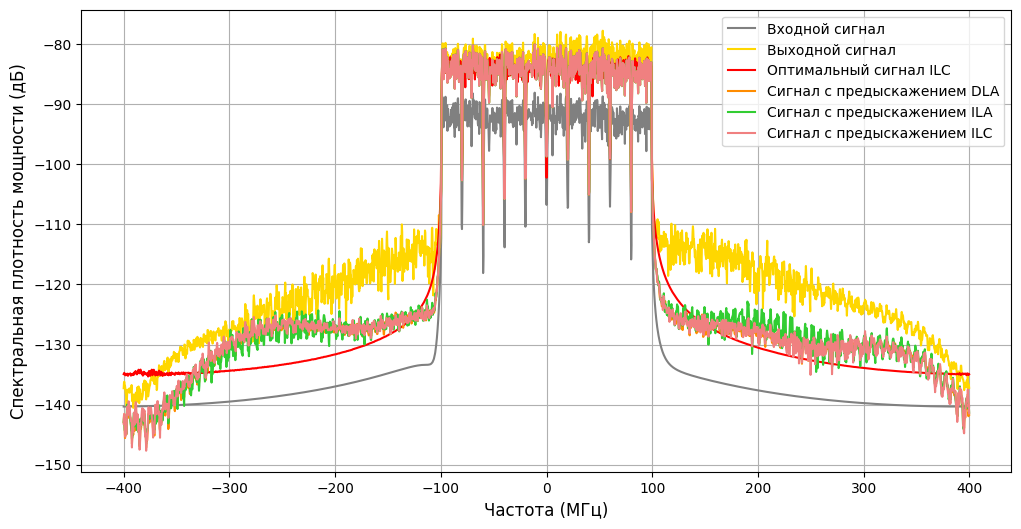

In [ ]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_dla)), color='darkorange', label='Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ila)), color='limegreen', label='Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ilc)), color='lightcoral', label='Сигнал с предыскажением ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [18]:
# moving_average
window_size = 60

freqs_s, spectrum_y_in_s = utils.moving_average(spectrum_y_in, freqs, fs, window_size)
_, spectrum_y_out_s = utils.moving_average(spectrum_y_out, freqs, fs, window_size)
_, spectrum_y_gmp_pa_s = utils.moving_average(spectrum_y_gmp_pa, freqs, fs, window_size)
_, spectrum_y_val_target_s = utils.moving_average(spectrum_y_val_target, freqs, fs, window_size)

# _, spectrum_y_dpd_dla_grad_s = utils.moving_average(spectrum_y_dpd_dla_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ila_grad_s = utils.moving_average(spectrum_y_dpd_ila_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ilc_grad_s = utils.moving_average(spectrum_y_dpd_ilc_grad, freqs, fs, window_size)

_, spectrum_y_linearized_dla_grad_s = utils.moving_average(spectrum_y_linearized_dla_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ila_grad_s = utils.moving_average(spectrum_y_linearized_ila_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ilc_grad_s = utils.moving_average(spectrum_y_linearized_ilc_grad, freqs, fs, window_size)

_, spectrum_u_k_s = utils.moving_average(spectrum_u_k, freqs, fs, window_size)
_, spectrum_u_k_pa_s = utils.moving_average(spectrum_u_k_pa, freqs, fs, window_size)



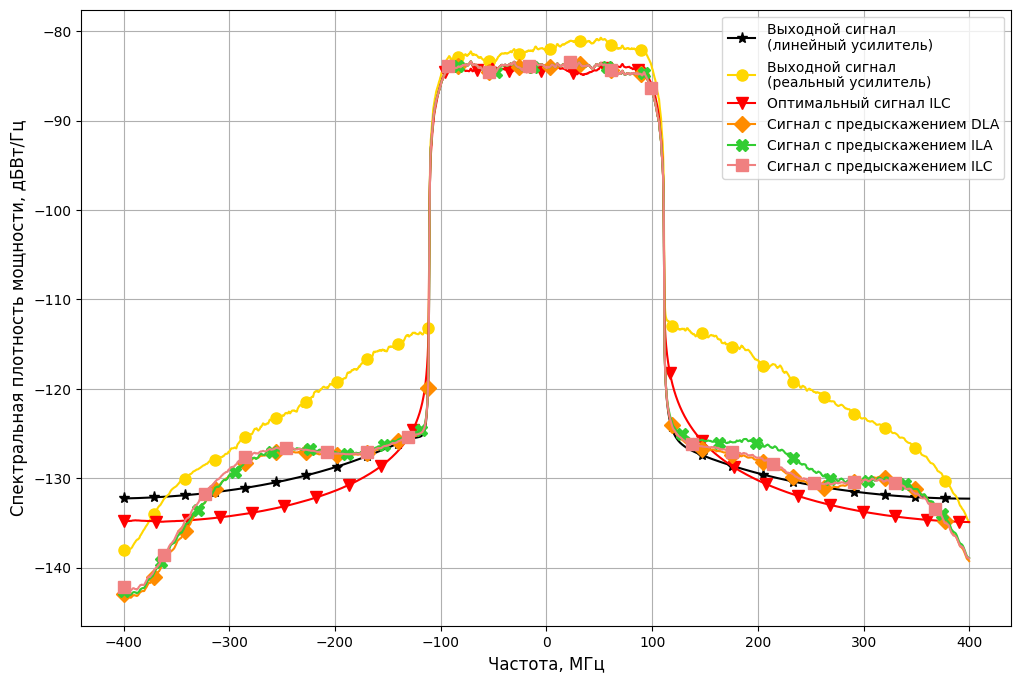

In [19]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa_s)), 
         color='gold', label='Выходной сигнал\n(реальный усилитель)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa_s)), 
         color='red', label='Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_grad_s)), 
         color='darkorange', label='Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ila_grad_s)), 
         color='limegreen', label='Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ilc_grad_s)), 
         color='lightcoral', label='Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


In [21]:
# spectra = [
#     (spectrum_y_in, 'grey', 'Входной сигнал'),
#     # (spectrum_y_out, 'k', 'Выходной сигнал'),
#     (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал модели'),
#     (spectrum_y_val_target, 'green', 'Идеальный линейный сигнал (k*In)'),
#     # (spectrum_u_k, 'magenta', 'u_k'),
#     (spectrum_u_k_pa, 'red', 'Оптимальный сигнал ILC'),
#     (spectrum_y_linearized_dla_grad, 'darkorange', 'Сигнал с предыскажением DLA'),
#     (spectrum_y_linearized_ila_grad, 'limegreen', 'Сигнал с предыскажением ILA'),
#     (spectrum_y_linearized_ilc_grad, 'lightcoral', 'Сигнал с предыскажением ILC')
# ]

# plotting.plot_signal_spectra(
#     freqs=freqs,
#     spectra=spectra,
#     title='Спектр сигнала',
#     xlabel='Частота (МГц)',
#     ylabel='Мощность (дБ)'
# )

AM/AM & AM/PM

In [22]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(x_val, y_val)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(x_val, y_val)

_, y_pa_am_am = metrics.calculate_am_am(x_val, y_gmp_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(x_val, y_gmp_pa)

_, y_val_target_am_am = metrics.calculate_am_am(x_val, y_val_target)
_, y_val_target_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_train, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_train, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_train, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_train, u_k_pa)

# dpd
_, y_dpd_dla_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_dla_grad)
_, y_dpd_dla_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_dla_grad)

_, y_dpd_ila_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_ila_grad)
_, y_dpd_ila_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_ila_grad)

_, y_dpd_ilc_grad_am_am = metrics.calculate_am_am(x_val, y_dpd_ilc_grad)
_, y_dpd_ilc_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_dpd_ilc_grad)

#linearized
_, y_linearized_dla_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_dla_grad)
_, y_linearized_dla_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_dla_grad)

_, y_linearized_ila_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_ila_grad)
_, y_linearized_ila_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_ila_grad)

_, y_linearized_ilc_grad_am_am = metrics.calculate_am_am(x_val, y_linearized_ilc_grad)
_, y_linearized_ilc_grad_phase_am_pm = metrics.calculate_am_pm(x_val, y_linearized_ilc_grad)


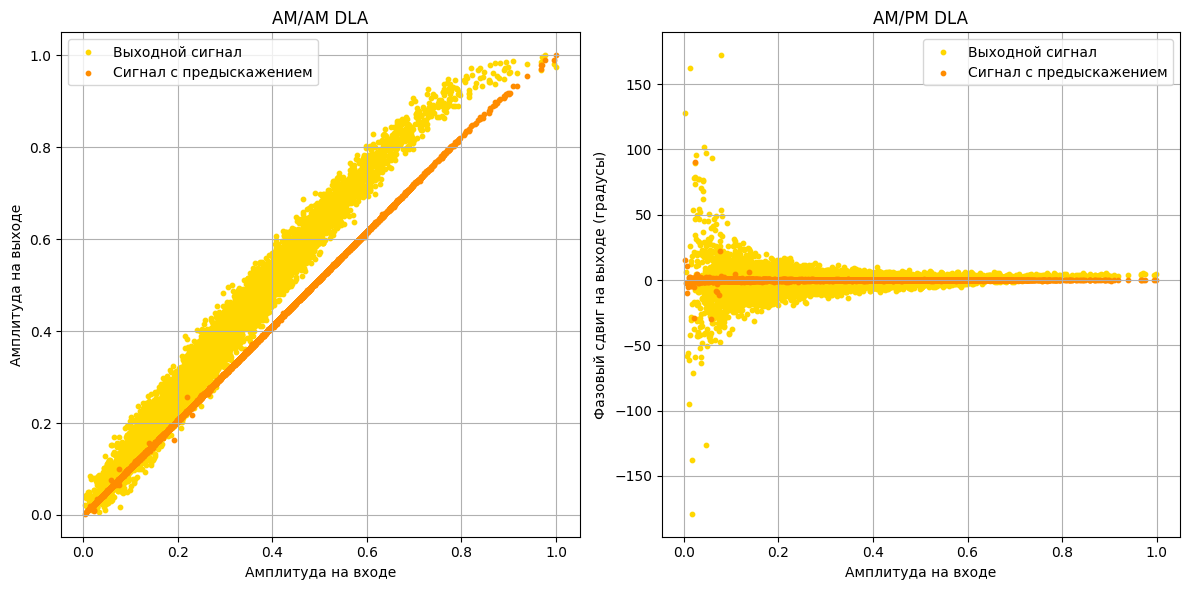

In [23]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_dla_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_dla_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_dla_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



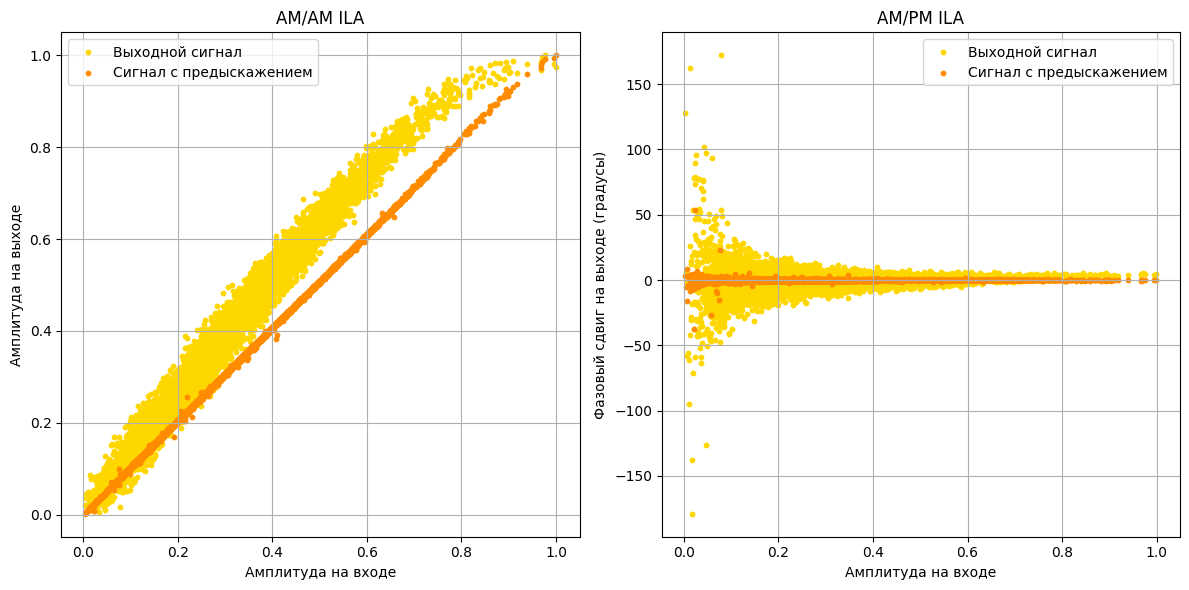

In [24]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ila_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ila_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ila_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


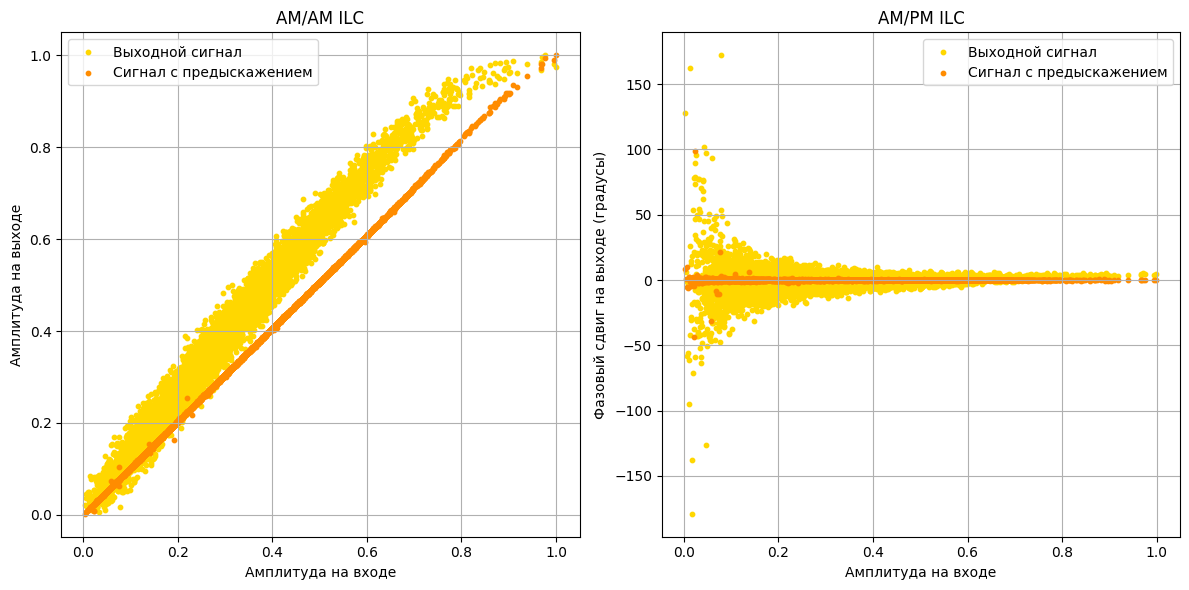

In [25]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_linearized_ilc_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ilc_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [5]:
snr_range = list(range(20, 61, 2))

epochs = 1000
lr = 0.01
num_realizations = 200

snr_params = params.make_snr_params(
    snr_range=snr_range,
    num_realizations=num_realizations,
    fs=fs,
    bw_main_ch=bw_sub_ch,
    epochs=epochs,
    learning_rate=lr,
    acpr_meter=acpr_meter,
    pa_model=pa_model,
    gain=gain
)

gmp_degree = 5
gmp_config = params.make_gmp_params(
    Ka=gmp_degree,
    La=gmp_degree,
    Kb=gmp_degree,
    Lb=gmp_degree,
    Mb=gmp_degree,
    Kc=gmp_degree,
    Lc=gmp_degree,
    Mc=gmp_degree,
    model_type=""
)

In [ ]:
dla_results = metrics.gmp_snr_metrics(arch_name='DLA', gmp_params=gmp_config, data_dict=data, snr_params=snr_params)

nmse_dla_list = dla_results['nmse']
acpr_left_dla_list = dla_results['acpr_left']
acpr_right_dla_list = dla_results['acpr_right']

Current SNR: 20
Epoch [0/1000], Loss: 0.37631887197494507
Epoch [100/1000], Loss: 0.10864121466875076
Epoch [200/1000], Loss: 0.10898105055093765
Epoch [300/1000], Loss: 0.1093946248292923
Epoch [400/1000], Loss: 0.11149702966213226
Epoch [500/1000], Loss: 0.10976366698741913
Epoch [600/1000], Loss: 0.10943294316530228
Epoch [700/1000], Loss: 0.10908430069684982
Epoch [800/1000], Loss: 0.11064315587282181
Epoch [900/1000], Loss: 0.10791757702827454
DLA optimization completed.
Current SNR: 22
Epoch [0/1000], Loss: 0.38917961716651917
Epoch [100/1000], Loss: 0.07726676017045975
Epoch [200/1000], Loss: 0.0761772021651268
Epoch [300/1000], Loss: 0.07691428065299988
Epoch [400/1000], Loss: 0.07702817767858505
Epoch [500/1000], Loss: 0.0769379585981369
Epoch [600/1000], Loss: 0.07769253104925156
Epoch [700/1000], Loss: 0.07658810913562775
Epoch [800/1000], Loss: 0.07686406373977661
Epoch [900/1000], Loss: 0.07798250019550323
DLA optimization completed.
Current SNR: 24
Epoch [0/1000], Loss: 0

In [ ]:
ila_results = metrics.gmp_snr_metrics(arch_name='ILA', gmp_params=gmp_config, data_dict=data, snr_params=snr_params)

nmse_ila_list = ila_results['nmse']
acpr_left_ila_list = ila_results['acpr_left']
acpr_right_ila_list = ila_results['acpr_right']

In [ ]:
ilc_results = metrics.gmp_snr_metrics(arch_name='ILC', gmp_params=gmp_config, data_dict=data, snr_params=snr_params)

nmse_uk_list = ilc_results['nmse_uk']
acpr_left_uk_list = ilc_results['acpr_left_uk']
acpr_right_uk_list = ilc_results['acpr_right_uk']

nmse_ilc_list = ilc_results['nmse']
acpr_left_ilc_list = ilc_results['acpr_left']
acpr_right_ilc_list = ilc_results['acpr_right']

In [32]:
def tensors_to_float(tensor_list):
    float_list = [t.item() for t in tensor_list]
    return float_list

nmse_dla_list = tensors_to_float(nmse_dla_list)
nmse_ila_list = tensors_to_float(nmse_ila_list)
nmse_ilc_list = tensors_to_float(nmse_ilc_list)
nmse_uk_list = tensors_to_float(nmse_uk_list)

In [33]:
print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {(nmse_dla_list)}")
print(f"acpr_left_dla_list = {acpr_left_dla_list}")
print(f"acpr_right_dla_list = {acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {nmse_ila_list}")
print(f"acpr_left_ila_list = {acpr_left_ila_list}")
print(f"acpr_right_ila_list = {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {nmse_ilc_list}")
print(f"acpr_left_ilc_list = {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {nmse_uk_list}")
print(f"acpr_left_uk_list = {acpr_left_uk_list}")
print(f"acpr_right_uk_list = {acpr_right_uk_list}")

snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

nmse_dla_list = [-17.154949188232422, -19.09251594543457, -21.044750213623047, -23.021923065185547, -25.002155303955078, -26.98126983642578, -28.954303741455078, -30.937488555908203, -32.90107345581055, -34.845218658447266, -36.755924224853516, -38.61607360839844, -40.426910400390625, -42.124752044677734, -43.687843322753906, -45.075897216796875, -46.248626708984375, -47.228172302246094, -47.92564010620117, -48.49229431152344, -48.84376907348633]
acpr_left_dla_list = [np.float64(-20.032896621274734), np.float64(-22.002898276331), np.float64(-23.980167111262954), np.float64(-25.985284041461938), np.float64(-27.943916970011372), np.float64(-29.91541877521779), np.float64(-31.871352771576074), np.float64(-33.797012660383636), np.float64(-35.67219414298505), np.float64(-37.49542101433636), np.float64(-39.210372332336746), np.float64(-40.8129737284458), np.float64(-42.2611022976035), np.float64

In [36]:
# значения в виде списков чтобы не рассчитывать снова все значения

snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

nmse_dla_list = [-17.154949188232422, -19.09251594543457, -21.044750213623047, -23.021923065185547, -25.002155303955078, -26.98126983642578, -28.954303741455078, -30.937488555908203, -32.90107345581055, -34.845218658447266, -36.755924224853516, -38.61607360839844, -40.426910400390625, -42.124752044677734, -43.687843322753906, -45.075897216796875, -46.248626708984375, -47.228172302246094, -47.92564010620117, -48.49229431152344, -48.84376907348633]
acpr_left_dla_list = [np.float64(-20.032896621274734), np.float64(-22.002898276331), np.float64(-23.980167111262954), np.float64(-25.985284041461938), np.float64(-27.943916970011372), np.float64(-29.91541877521779), np.float64(-31.871352771576074), np.float64(-33.797012660383636), np.float64(-35.67219414298505), np.float64(-37.49542101433636), np.float64(-39.210372332336746), np.float64(-40.8129737284458), np.float64(-42.2611022976035), np.float64(-43.489963007240796), np.float64(-44.48969779871533), np.float64(-45.26628275458397), np.float64(-45.82507862711507), np.float64(-46.26964161953022), np.float64(-46.544344312319446), np.float64(-46.7247453176207), np.float64(-46.8625007497271)]
acpr_right_dla_list = [np.float64(-20.03067217721715), np.float64(-22.023901072994782), np.float64(-23.999487986191852), np.float64(-25.990288997195552), np.float64(-27.97879723510448), np.float64(-29.93405882623138), np.float64(-31.885189566353002), np.float64(-33.83402270942291), np.float64(-35.73882672394366), np.float64(-37.591940638042516), np.float64(-39.35400356485398), np.float64(-41.02262823000135), np.float64(-42.529186070031216), np.float64(-43.87146478243156), np.float64(-44.98060385142986), np.float64(-45.87641689390573), np.float64(-46.57500010862354), np.float64(-47.01434234515064), np.float64(-47.360535320706695), np.float64(-47.54855205738099), np.float64(-47.716042344669965)]

nmse_ila_list = [-17.14900016784668, -19.082727432250977, -21.0418701171875, -23.009443283081055, -24.970191955566406, -26.952104568481445, -28.929380416870117, -30.873485565185547, -32.79220199584961, -34.68447494506836, -36.50259017944336, -38.23097229003906, -39.86079025268555, -41.318084716796875, -42.59962463378906, -43.62651062011719, -44.414581298828125, -45.008975982666016, -45.430274963378906, -45.73917007446289, -45.99494552612305]
acpr_left_ila_list = [np.float64(-20.023492672712504), np.float64(-22.00194266264846), np.float64(-23.982589695597863), np.float64(-25.971010353814368), np.float64(-27.954582475654398), np.float64(-29.883061513651946), np.float64(-31.84119207223084), np.float64(-33.741020731136594), np.float64(-35.59542076282507), np.float64(-37.389910008838555), np.float64(-39.05389357257544), np.float64(-40.57882064420808), np.float64(-41.87301807298115), np.float64(-43.028623797072676), np.float64(-43.97164913381233), np.float64(-44.47478498942156), np.float64(-45.094347042181134), np.float64(-45.44431979439592), np.float64(-45.6689972060291), np.float64(-45.81347702948893), np.float64(-45.919890365450364)]
acpr_right_ila_list = [np.float64(-20.037619673095683), np.float64(-22.02154157779769), np.float64(-24.00141855357515), np.float64(-25.97407114783849), np.float64(-27.954493059455036), np.float64(-29.931848642514495), np.float64(-31.87500171448285), np.float64(-33.78634424089804), np.float64(-35.682854215253045), np.float64(-37.49031966564913), np.float64(-39.21893888309752), np.float64(-40.82172035769772), np.float64(-42.24376419843244), np.float64(-43.494933171804725), np.float64(-44.48705283113159), np.float64(-45.28125077526404), np.float64(-45.82150567692158), np.float64(-46.23586524416965), np.float64(-46.483727735029944), np.float64(-46.80989034343764), np.float64(-46.76467487891643)]

nmse_ilc_list = [-17.161582946777344, -19.08861541748047, -21.052515029907227, -23.02472496032715, -25.0006103515625, -26.98052978515625, -28.957475662231445, -30.93657875061035, -32.8939208984375, -34.8338737487793, -36.754276275634766, -38.548091888427734, -40.303565979003906, -41.94981002807617, -43.43807601928711, -44.752685546875, -45.811702728271484, -46.68809509277344, -47.2928581237793, -47.732051849365234, -48.105037689208984]
acpr_left_ilc_list = [np.float64(-20.04499601993586), np.float64(-22.000575773262312), np.float64(-24.005173164637622), np.float64(-25.975381528613166), np.float64(-27.948773007731976), np.float64(-29.904547380654257), np.float64(-31.83497348292303), np.float64(-33.76508347209344), np.float64(-35.63135714041884), np.float64(-37.43372467772184), np.float64(-39.14673797702895), np.float64(-40.682020346354115), np.float64(-42.074796748562314), np.float64(-43.25955583198558), np.float64(-44.172655984033355), np.float64(-44.92677486420471), np.float64(-45.42858744174152), np.float64(-45.81765459787905), np.float64(-46.0679249887625), np.float64(-46.22621768342928), np.float64(-46.348104813507604)]
acpr_right_ilc_list = [np.float64(-20.055033821205793), np.float64(-22.02296109860739), np.float64(-24.011375645858735), np.float64(-25.989965909004713), np.float64(-27.974052697082097), np.float64(-29.94138650953073), np.float64(-31.89681741205028), np.float64(-33.840142017577605), np.float64(-35.730656379008416), np.float64(-37.598354712999864), np.float64(-39.381993008609946), np.float64(-41.00939897421255), np.float64(-42.49628648885533), np.float64(-43.81904566125652), np.float64(-44.926036747000865), np.float64(-45.77697004484083), np.float64(-46.456832260637114), np.float64(-46.9203740307759), np.float64(-47.219135964704975), np.float64(-47.42920449390439), np.float64(-47.62513932513492)]

nmse_uk_list = [-17.094663619995117, -19.016490936279297, -20.960582733154297, -22.905410766601562, -24.86489486694336, -26.823619842529297, -28.778156280517578, -30.729806900024414, -32.679481506347656, -34.633670806884766, -36.5738410949707, -38.51299285888672, -40.44480514526367, -42.37684631347656, -44.29717254638672, -46.236045837402344, -48.150821685791016, -50.04896926879883, -51.969764709472656, -53.85963439941406, -55.72507858276367]
acpr_left_uk_list = [np.float64(-19.99438441289194), np.float64(-21.9658512665871), np.float64(-23.945869167743208), np.float64(-25.92128162743692), np.float64(-27.9018250793472), np.float64(-29.857668613519994), np.float64(-31.830175197925897), np.float64(-33.76021792312188), np.float64(-35.677025441911994), np.float64(-37.586095603435375), np.float64(-39.42729918519659), np.float64(-41.22707557884934), np.float64(-42.936348574753275), np.float64(-44.508877373457345), np.float64(-45.93217114866118), np.float64(-47.16637553054871), np.float64(-48.16740369704331), np.float64(-48.992740555776834), np.float64(-49.56517529961033), np.float64(-50.01273812436431), np.float64(-50.31230743627908)]
acpr_right_uk_list = [np.float64(-19.908159326520842), np.float64(-21.85695263610488), np.float64(-23.818630432812846), np.float64(-25.74280605561588), np.float64(-27.685123164021324), np.float64(-29.597578780431057), np.float64(-31.50956145186845), np.float64(-33.408043631235536), np.float64(-35.2641539488935), np.float64(-37.11290256809776), np.float64(-38.87993901305795), np.float64(-40.61697803065708), np.float64(-42.25138725427255), np.float64(-43.7730148204967), np.float64(-45.139205723386205), np.float64(-46.40286494928455), np.float64(-47.41226707888618), np.float64(-48.2239296586826), np.float64(-48.8718445889375), np.float64(-49.305717773680755), np.float64(-49.67857146555004)]

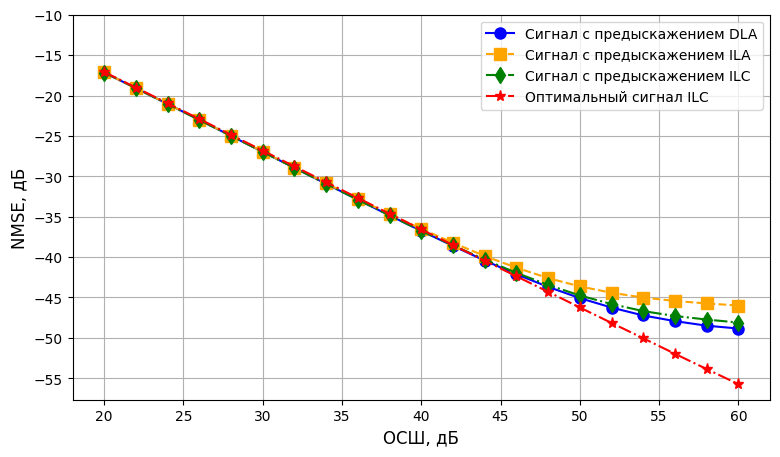

In [37]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


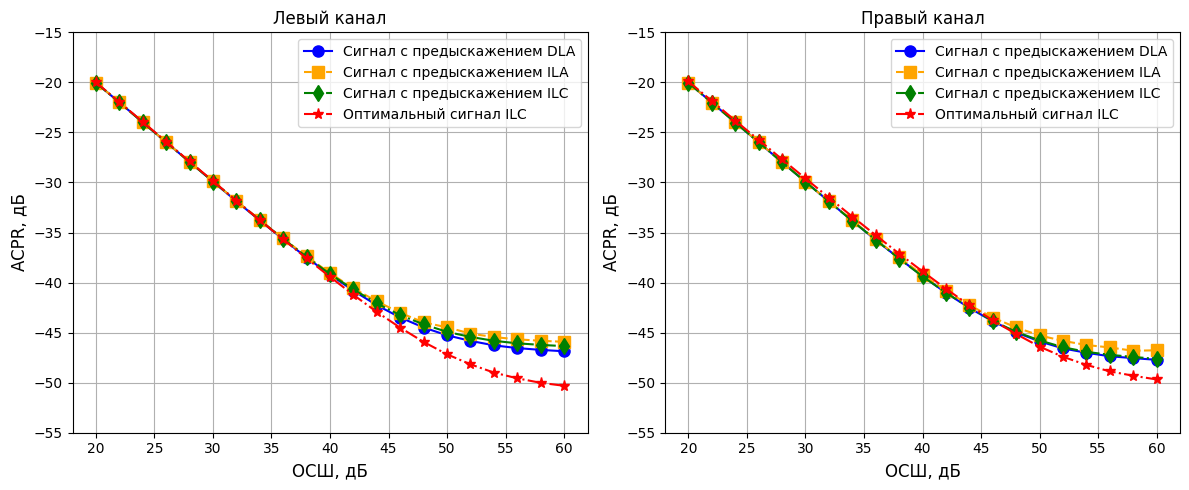

In [38]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, acpr_left_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_left_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_left_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_right_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_right_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()